In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

In [2]:
import os
os.getcwd()

'/Users/vkalghatgi/Dropbox/Protocol_Labs/mechafil-jax-notebooks/baseline_project/Hybrid_Consensus_Pledge'

In [48]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import os
from datetime import date, timedelta

import numpy as np
import jax.numpy as jnp
import pandas as pd

import mechafil.data as mecha_data
import mechafil.sim as np_sim

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C
import mechafil_jax.minting as minting

import scenario_generator.utils as u
import scenario_generator.curated as curated

import warnings 
warnings.filterwarnings('ignore')

In [49]:
# Constants 
EIB = 2 ** 60
PIB = 2 ** 50
TIB = 2 ** 40
GIB = 2 ** 30
SECTOR_SIZE = 32 * GIB

# Useful Function
def add_generated_quantities(cil_rbp, duration=365)->pd.DataFrame:
    # add ROI to trajectory df
    cil_rbp['day_pledge_per_QAP'] = SECTOR_SIZE * (cil_rbp['day_locked_pledge']-cil_rbp['day_renewed_pledge'])/(cil_rbp['qa_day_onboarded_power_pib']*PIB)
    cil_rbp['day_rewards_per_sector'] = SECTOR_SIZE * cil_rbp.day_network_reward / (cil_rbp.network_QAP_EIB * EIB)
    
    cil_rbp['1y_return_per_sector'] = cil_rbp['day_rewards_per_sector'].rolling(365).sum().shift(-365+1).values.flatten()
    cil_rbp['1y_sector_roi'] = cil_rbp['1y_return_per_sector'] / cil_rbp['day_pledge_per_QAP']

    return cil_rbp

## Data 

In [77]:
token = '/Users/vkalghatgi/Dropbox/Mac/Desktop/vik_spacescope_auth.json'

start_date = date(2023,10,10)
current_date = date.today() - timedelta(days=3)
forecast_length = 365*5
end_date = current_date + timedelta(days=forecast_length)
offline_data = data.get_simulation_data(token, start_date, current_date, end_date)

print(start_date, current_date, end_date)

2023-10-10 2023-10-14 2028-10-12


5.1776123046875 6.550550842285157 3.4984832763671876 0.5773961026388577 0.9747681454581169


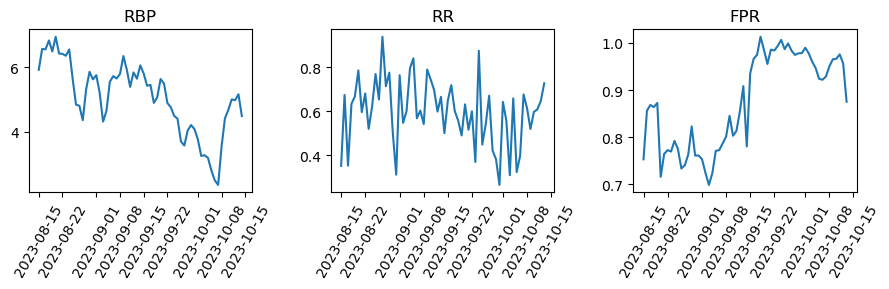

In [138]:
# Quick EDA of Recent Onboarding and Renewal Trends 
t_hist_rbp, hist_rbp = u.get_historical_daily_onboarded_power(current_date-timedelta(days=60), current_date)
t_hist_rr, hist_rr = u.get_historical_renewal_rate(current_date-timedelta(days=60), current_date)
t_hist_fpr, hist_fpr = u.get_historical_filplus_rate(current_date-timedelta(days=60), current_date)

smoothed_last_historical_rbp_median = np.median(hist_rbp[-60:])
smoothed_last_historical_rbp_optimistic = np.percentile(hist_rbp[-60:], 95)
smoothed_last_historical_rbp_pessimistic = np.percentile(hist_rbp[-60:], 10)
smoothed_last_historical_rr = np.median(hist_rr[-30:])
smoothed_last_historical_fpr = np.median(hist_fpr[-30:])

print(smoothed_last_historical_rbp_median, smoothed_last_historical_rbp_optimistic, 
      smoothed_last_historical_rbp_pessimistic, 
      smoothed_last_historical_rr, smoothed_last_historical_fpr)

# Plot 
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.plot(t_hist_rbp, hist_rbp)
plt.xticks(rotation=60)
plt.title('RBP')

plt.subplot(1,3,2)
plt.plot(t_hist_rr, hist_rr)
plt.xticks(rotation=60)
plt.title('RR')

plt.subplot(1,3,3)
plt.plot(t_hist_fpr, hist_fpr)
plt.xticks(rotation=60)
plt.title('FPR')

plt.tight_layout()
plt.show()

In [134]:
forecast_length

1825

In [79]:
g = np.log(2)/(365)
# Define Scenarios From this Document https://docs.google.com/document/d/1aD6mvbkisey_iUQ6VTuiicdYXYeVG5mDXdhEsVd0kPY/edit#heading=h.7f1lntj8edxh
#optimistic = 15
#pessimistic = 3
#status_quo = 6

baseline = minting.compute_baseline_power_array(
    np.datetime64(start_date), np.datetime64(end_date), offline_data['init_baseline_eib'],
)

scenarios = {
    'status_quo': {
        'rbp': np.ones(forecast_length) * smoothed_last_historical_rbp_median,
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    'optimistic': {
        'rbp': curated.linear_increase_and_plateau(
            smoothed_last_historical_rbp_optimistic,
            smoothed_last_historical_rbp_optimistic * 3,
            forecast_length,
            forecast_length
        ), 
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    'pessimistic': {
        'rbp': np.ones(forecast_length) * smoothed_last_historical_rbp_pessimistic,
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
}

colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples']]

In [137]:
 smoothed_last_historical_rbp_pessimistic

3.524139404296875

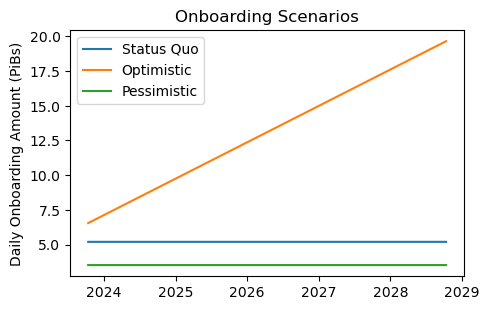

In [136]:
# plot the RBP trajectories for comparison
plt.figure(figsize=(5,3))
plt.plot(t[-forecast_length:], scenarios['status_quo']['rbp'], label='Status Quo')
plt.plot(t[-forecast_length:], scenarios['optimistic']['rbp'], label='Optimistic')
plt.plot(t[-forecast_length:], scenarios['pessimistic']['rbp'], label='Pessimistic')
#plt.plot(baseline, linestyle=':', color='k', label='Baseline')
plt.ylabel('Daily Onboarding Amount (PiBs)')
plt.legend()
#plt.yscale('log')
plt.tight_layout()
plt.title('Onboarding Scenarios')

plt.savefig('Onboarding_Scenarios', bbox_inches='tight')

## Simulations

In [81]:
# Parameter Setting
base_case = True
gamma_weights = [0, 0.3, 0.5, 0.7,0.9, 1]
gamma_weights2 = [0.7, 1]

if base_case is True: 
    gamma_weights = gamma_weights2
gamma_weight_types = [0,1,2]
lock_target_val = 0.3
lock_target_trajectory = jnp.ones(forecast_length) * lock_target_val
sector_duration = 365
scenario2results_full = {}

nan_array = np.full(sector_duration-1, np.nan)
for scenario_name, trajectories in scenarios.items(): 
    rbp = jnp.array(trajectories['rbp'])
    rr = jnp.array(trajectories['rr'])
    fpr = jnp.array(trajectories['fpr'])
    scenario2results_full[scenario_name] = {}
    
    for gamma_weight_type in gamma_weight_types: 
        scenario2results_full[scenario_name][str(gamma_weight_type)] = {}
        
        for gamma in gamma_weights: 
            simulation_results = sim.run_sim(
                rbp, 
                rr, 
                fpr, 
                lock_target_trajectory, 
                start_date, 
                current_date, 
                forecast_length, 
                sector_duration, 
                offline_data, 
                gamma=gamma, 
                gamma_weight_type=gamma_weight_type,
            )
            
            
            simulation_results['1y_return_per_sector'] = np.concatenate((simulation_results['1y_return_per_sector'], nan_array))
            simulation_results['1y_sector_roi'] = np.concatenate((simulation_results['1y_sector_roi'], nan_array))
            simulation_results = pd.DataFrame(simulation_results)
           # simulation_results['']
           # simulation_results = add_generated_quantities(simulation_results, duration=sector_duration)
            scenario2results_full[scenario_name][str(gamma_weight_type)][str(gamma)] = simulation_results

#1y_return_per_sector 
# 1y_sector_roi 

In [84]:
# Construct New Dicts for Easier Plotting 
arithmetic_weight_type = str(0)
geometric_weight_type = str(1)
harmonic_weight_type = str(2)
scenario2results_arithmetic = {}
scenario2results_geometric = {}
scenario2results_harmonic = {}

for gamma in gamma_weights: 
    scenario2results_arithmetic[str(gamma)] = {}
    scenario2results_geometric[str(gamma)] = {}
    scenario2results_harmonic[str(gamma)] = {}
    for scenario_name in scenario2results_full.keys(): 
        scenario2results_arithmetic[str(gamma)][scenario_name] = scenario2results_full[scenario_name][arithmetic_weight_type][str(gamma)]
        scenario2results_geometric[str(gamma)][scenario_name] = scenario2results_full[scenario_name][geometric_weight_type][str(gamma)]
        scenario2results_harmonic[str(gamma)][scenario_name] = scenario2results_full[scenario_name][harmonic_weight_type][str(gamma)]
    
scenario2results_new = {'arithmetic': scenario2results_arithmetic,
                       'geometric': scenario2results_geometric, 
                       'harmonic': scenario2results_harmonic}

## Plots

In [144]:
#Plotting Functions
def plot_x(ax, results, key, labels, colors, scale_by=1, linestyle='-', alpha=1):
    for ii, scenario in enumerate(labels):
        res = results[scenario]
        ax.plot(t, res[key]/scale_by, label=scenario, color=colors[ii], linestyle=linestyle, alpha=alpha)
        
    for tick in ax.get_xticklabels():
        tick.set_rotation(60)
        
def plot_macroeconomic_weighting(total_sim_len,
                                 t, 
                                 scenario2results, 
                                 gamma_weights, 
                                 gamma_weight_type, 
                                 base_case = False,
                                ):
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8,8))

    c_vec = [c(0.6) for c in colors]
    
    for idx, gamma_scenario in enumerate(gamma_weights): 
        spacing = 0.8 / len(gamma_weights)
        alpha = 0.2 + spacing*idx
        
        if base_case is True: 
            alpha = 1 - alpha
              
        #alpha = min(gamma_scenario+0.1, 1)
        gamma_scenario = str(gamma_scenario)
        linestyle = '-'

        keys = list(scenario2results[gamma_scenario].keys())
        axx = ax[0, 0]
        plot_x(axx, scenario2results[gamma_scenario], 'rb_total_power_eib', keys, c_vec, linestyle=linestyle)
        #axx.set_yscale('log')
        axx.set_ylabel('EiB')
        axx.set_title('RBP')
        # Dont need to duplicate legends

        axx = ax[0, 1]
        plot_x(axx, scenario2results[gamma_scenario], 'qa_total_power_eib', keys, c_vec, linestyle=linestyle)
      #  plot_x(axx, scenario2results[gamma_scenario], 'network_time')
        #axx.set_yscale('log')
        axx.set_ylabel('EiB')
        axx.set_title('QAP')
        if gamma_scenario == str(0): 
            axx.legend(bbox_to_anchor=(1,0.8))
        if base_case is True and gamma_scenario == str(0.7): 
            axx.legend(bbox_to_anchor=(1,0.8), title='Onboarding_Scenario')

        axx = ax[1, 0]
        plot_x(axx, scenario2results[gamma_scenario], 'day_network_reward', keys, c_vec, linestyle=linestyle)
        axx.set_ylabel('FIL/day')
        axx.set_ylim(0)
        axx.set_title('Minting Rate')

        axx = ax[1, 1]
        plot_x(axx, scenario2results[gamma_scenario], 'network_locked', keys, c_vec, scale_by=1e6, linestyle=linestyle, alpha=alpha)
        axx.set_ylabel('M-FIL')
        axx.set_title('Network Locked')
        axx.axhline(0, linestyle=':', color='k')

        axx = ax[2, 0]
        plot_x(axx, scenario2results[gamma_scenario], 'circ_supply', keys, c_vec, scale_by=1e6, linestyle=linestyle, alpha=alpha)
        axx.set_ylabel('M-FIL')
        axx.set_title('Circulating Supply')

        axx = ax[2, 1]

        for ii, scenario in enumerate(keys):
            res = scenario2results[gamma_scenario][scenario]
            axx.plot(t, res['network_locked']/res['circ_supply'], label= str(gamma_scenario)+':'+keys[ii], color=c_vec[ii], linestyle=linestyle, alpha=alpha)
        for tick in axx.get_xticklabels():
            tick.set_rotation(60)
        axx.set_title('L/CS')

        #axx = ax[3,0]
        #plot_x(axx, scenario2results[gamma_scenario], 'day_pledge_per_QAP', keys, c_vec, linestyle=linestyle)
        #axx.set_ylabel('FIL')
        #axx.set_title('Pledge/32GiB QA Sector')
        #axx.set_ylim(0)

       #axx = ax[3,1]
        #plot_x(axx, scenario2results[gamma_scenario], '1y_sector_roi', keys, c_vec, scale_by=.01, linestyle=linestyle)
        #axx.set_ylabel('FIL')
        #axx.set_title('1Y Realized FoFR')
        #axx.set_ylim(0)

    fig.suptitle('Network Macroeconomic KPIs: Current vs Hybrid Pledge Model ' + gamma_weight_type + ' Weighting' )
    
    if base_case is True: 
        fig.suptitle('Network Macroeconomic KPIs: Current vs Mixed Consensus Pledge Model')
        
    # Create a list to store the legend handles
    legend_handles = []

    # Loop through the gamma weights and create Line2D objects for each gamma_scenario
    for idx, gamma_scenario in enumerate(gamma_weights):  
        spacing = 0.8 / len(gamma_weights)
        alpha = 0.2 + spacing*idx
        
        if base_case is True: 
            alpha = 1 - alpha 
            if gamma_scenario == 1: 
                label = 'Current_(No Change)'
            elif gamma_scenario == 0.7: 
                label = 'Mixed_Consensus_Pledge'
            line = Line2D([], [], linestyle='-', color='black', label=label, alpha=alpha)
            legend_handles.append(line)
        else:            
            label = f'Gamma={gamma_scenario}'
            line = Line2D([], [], linestyle='-', color='black', label=label, alpha=alpha)
            legend_handles.append(line)


    # Add the legend to the plot
    fig.legend(handles=legend_handles, bbox_to_anchor=(1, 0.97), loc='upper right', title='Consensus_Pledge_Mechanism')
    plt.tight_layout()
 
    if base_case is True: 
         plt.savefig('Network Macroeconomic KPIs: Current vs Hybrid Pledge Model_Base_Case.png', bbox_inches='tight')
    else: 
        plt.savefig('Network Macroeconomic KPIs: Current vs Hybrid Pledge Model ' + gamma_weight_type + ' Weighting.png', bbox_inches='tight')

    # Adjust the layout to make space for the legend
    #plt.subplots_adjust(right=0.85)

    # Display the plot
    #plt.show()

In [145]:
def plot_microeconomic_trajectories(total_sim_len,
                                    t, 
                                    scenario2results, 
                                    gamma_weights, 
                                    gamma_weight_type,
                                    base_case=False,
                                   ):

    c_vec = [c(0.6) for c in colors]
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,8))

    for idx, gamma_scenario in enumerate(gamma_weights):
        spacing = 0.8 / len(gamma_weights)
        alpha = 0.2 + spacing*idx
        
        if base_case is True: 
            alpha = 1 - alpha
        
        gamma_scenario = str(gamma_scenario)
        keys = list(scenario2results[gamma_scenario].keys())
        linestyle = '-'

        axx = ax[0]
        plot_x(axx, scenario2results[gamma_scenario], 'day_pledge_per_QAP', keys, c_vec, linestyle=linestyle, alpha=alpha)
        axx.set_ylabel('FIL')
        if base_case is True: 
            axx.set_title('Pledge/32 GiB QA Sector')
        else:
            axx.set_title('Pledge/32GiB QA Sector: ' + gamma_weight_type )
        axx.set_ylim(0)
        #axx.legend(bbox_to_anchor=(1,0.5))
        if gamma_scenario == str(0): 
            axx.legend(bbox_to_anchor=(1, 0.8))
           # axx.legend(alpha=1)
        if base_case is True and gamma_scenario == str(0.7): 
            axx.legend(bbox_to_anchor=(1, 0.8), title='Onboarding Scenario')

        axx = ax[1]
        plot_x(axx, scenario2results[gamma_scenario], '1y_sector_roi', keys, c_vec, scale_by=.01, linestyle=linestyle, alpha=alpha)
        axx.set_ylabel('FIL')
        axx.set_title('1Y Realized FoFR: ' + gamma_weight_type)
        axx.set_ylim(0, 60)
        
       # axx = ax[1,0]
        #scenario2results[gamma_scenario]['Normalized L/CS'] = 
        

    legend_handles = []
    
    for idx, gamma_scenario in enumerate(gamma_weights):  
        spacing = 0.8 / len(gamma_weights)
        alpha = 0.2 + spacing*idx
        
        if base_case is True: 
            alpha = 1 - alpha 
            if gamma_scenario == 1: 
                label = 'Current_(No Change)'
            elif gamma_scenario == 0.7: 
                label = 'Mixed_Consensus_Pledge'
            line = Line2D([], [], linestyle='-', color='black', label=label, alpha=alpha)
            legend_handles.append(line)
        else:            
            label = f'Gamma={gamma_scenario}'
            line = Line2D([], [], linestyle='-', color='black', label=label, alpha=alpha)
            legend_handles.append(line)

    # Add the legend to the plot
    fig.legend(handles=legend_handles, bbox_to_anchor=(1, 0.97), loc='upper right', title='Consensus_Pledge_Mechanism')
    plt.tight_layout()
    
    if base_case is True: 
        plt.savefig('Pledge_and_FoFR: Current Pledge vs Hybrid Consensus Pledge.png' , bbox_inches='tight')

### Arithmetic Weighting 

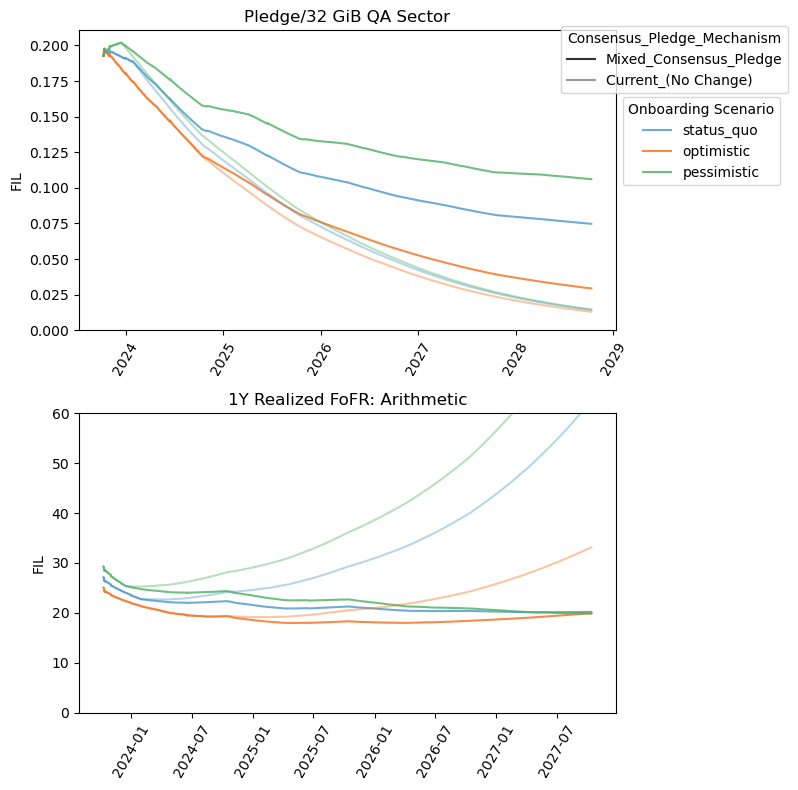

In [142]:
total_sim_len = (end_date - start_date).days
t = [start_date + timedelta(days=i) for i in range(total_sim_len)]
gamma_weight_type = 'Arithmetic'
scenario2results = scenario2results_arithmetic
plot_microeconomic_trajectories(total_sim_len,
                                t, 
                                scenario2results, 
                                gamma_weights, 
                                gamma_weight_type=gamma_weight_type, 
                                base_case=True

                            )

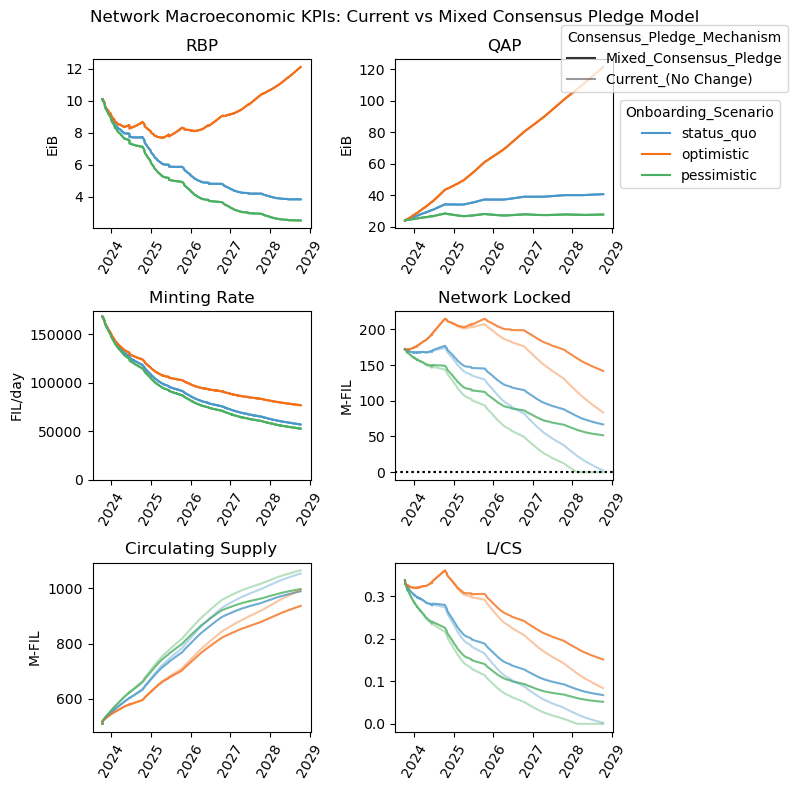

In [154]:
total_sim_len = (end_date - start_date).days
t = [start_date + timedelta(days=i) for i in range(total_sim_len)]
gamma_weight_type = 'Arithmetic'
scenario2results = scenario2results_arithmetic
scenario2results['1']['pessimistic']['network_locked'] = scenario2results['1']['pessimistic']['network_locked'].clip(lower=0)

plot_macroeconomic_weighting(total_sim_len,
                             t, 
                             scenario2results, 
                             gamma_weights, 
                             gamma_weight_type=gamma_weight_type,
                             base_case = True,
                            )

In [153]:
scenario2results['1']['pessimistic']['network_locked'] = scenario2results['1']['pessimistic']['network_locked'].clip(lower=0)

### Time Sensitivity 

In [17]:
curr_dict = scenario2results_arithmetic['1']
new_dict = scenario2results_arithmetic['0.7']

diff_dict = {}
for onboarding_scenario in curr_dict.keys(): 
    new_df = new_dict[onboarding_scenario]
    curr_df = curr_dict[onboarding_scenario]
    diff_dict[onboarding_scenario] = new_df - curr_df
    
    locked_over_cs_diff = new_df['network_locked']/new_df['circ_supply'] - curr_df['network_locked']/curr_df['circ_supply']
    
    day_pledge_diff = (new_df['day_locked_pledge'] - new_df['day_renewed_pledge']) - (curr_df['day_locked_pledge'] - curr_df['day_renewed_pledge'])
    
    day_pledge_per_QAP_percent =  (new_df['day_pledge_per_QAP'] - curr_df['day_pledge_per_QAP'])/(curr_df['day_pledge_per_QAP'])
    
    network_locked_percent =(new_df['network_locked'] - curr_df['network_locked']) / curr_df['network_locked']
    
    diff_dict[onboarding_scenario]['locked_over_cs'] = locked_over_cs_diff
    diff_dict[onboarding_scenario]['day_new_pledge'] = day_pledge_diff
    diff_dict[onboarding_scenario]['day_pledge_per_QAP_percent'] = day_pledge_per_QAP_percent
    diff_dict[onboarding_scenario]['network_locked_percent'] = network_locked_percent
    


In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8,8))
# Plotting Diffs

time = 540
ax = axs[0]
for onboarding_scenario in diff_dict.keys(): 
    label = onboarding_scenario
    df = diff_dict[onboarding_scenario]
    ax.plot(t[:time], df['day_pledge_per_QAP'][:time] * 2**20 / 32, label=label)
ax.set_title('Increase in FIL per PiB of QAP')
ax.set_ylabel('FIL per PiB of QAP')
ax.legend()

ax = axs[1]
for onboarding_scenario in diff_dict.keys(): 
    label = onboarding_scenario
    df = diff_dict[onboarding_scenario]
    ax.plot(t[:time], df['day_pledge_per_QAP_percent'][:time] * 1e2)
ax.set_title('% Increase')
ax.set_ylabel('%')
#ax.set_ylim(0,20)
#ax.set_xlim(2024, 2025)

fig.suptitle('Step Increase in Pledge Current Protocol vs Proposed Solution')
plt.tight_layout()

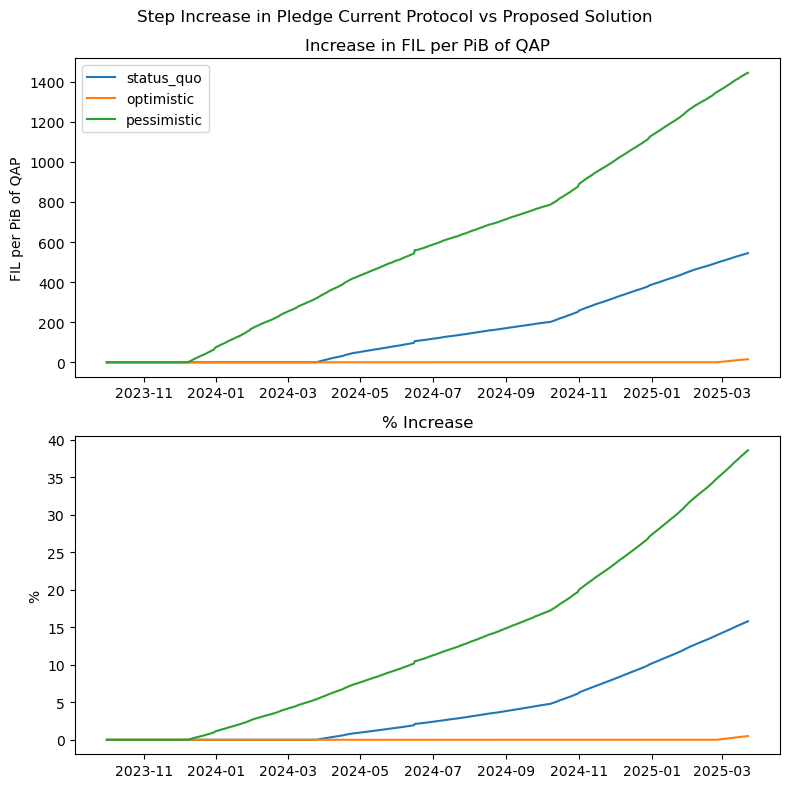

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(8,8))
# Plotting Diffs

time = 540
ax = axs[0]
for onboarding_scenario in diff_dict.keys(): 
    label = onboarding_scenario
    df = diff_dict[onboarding_scenario]
    ax.plot(t[:time], df['day_pledge_per_QAP'][:time] * 2**20 / 32, label=label)
ax.set_title('Increase in FIL per PiB of QAP')
ax.set_ylabel('FIL per PiB of QAP')
ax.legend()

ax = axs[1]
for onboarding_scenario in diff_dict.keys(): 
    label = onboarding_scenario
    df = diff_dict[onboarding_scenario]
    ax.plot(t[:time], df['day_pledge_per_QAP_percent'][:time] * 1e2)
ax.set_title('% Increase')
ax.set_ylabel('%')
#ax.set_ylim(0,20)
#ax.set_xlim(2024, 2025)

fig.suptitle('Step Increase in Pledge Current Protocol vs Proposed Solution')
plt.tight_layout()

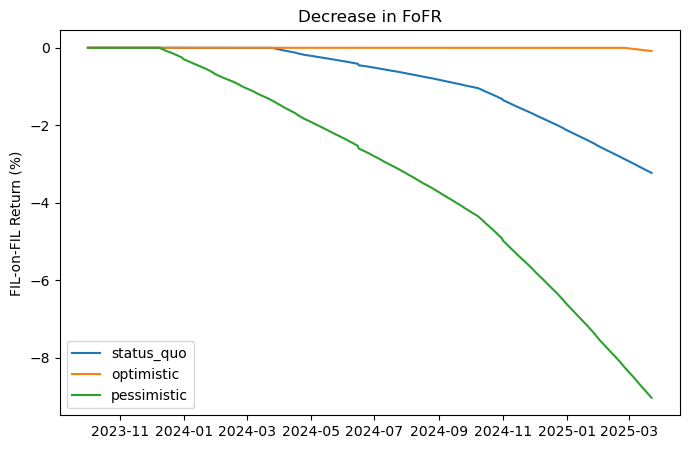

In [19]:
# FOFR
time = 540
plt.figure(figsize=(8,5))
#ax = axs[0]
for onboarding_scenario in diff_dict.keys(): 
    label = onboarding_scenario
    df = diff_dict[onboarding_scenario]
    plt.plot(t[:time], df['1y_sector_roi'][:time] * 100, label=label)
plt.title('Decrease in FoFR')
plt.ylabel('FIL-on-FIL Return (%)')
plt.legend()




Text(0.5, 1.0, 'Difference in FoFR - Current Protocol vs Hybrid Consensus')

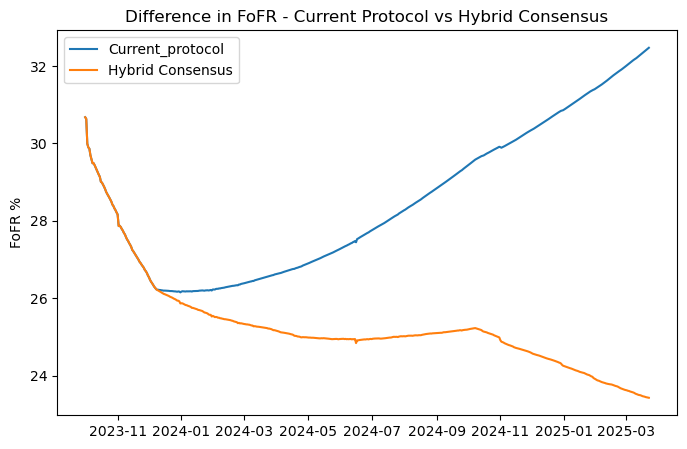

In [20]:
plt.figure(figsize=(8,5))
time = 540
plt.plot(t[:time], curr_df['1y_sector_roi'][:time] * 100, label='Current_protocol')
plt.plot(t[:time], new_df['1y_sector_roi'][:time] * 100, label='Hybrid Consensus')
plt.legend()
plt.ylabel('FoFR %')
plt.title('Difference in FoFR - Current Protocol vs Hybrid Consensus')

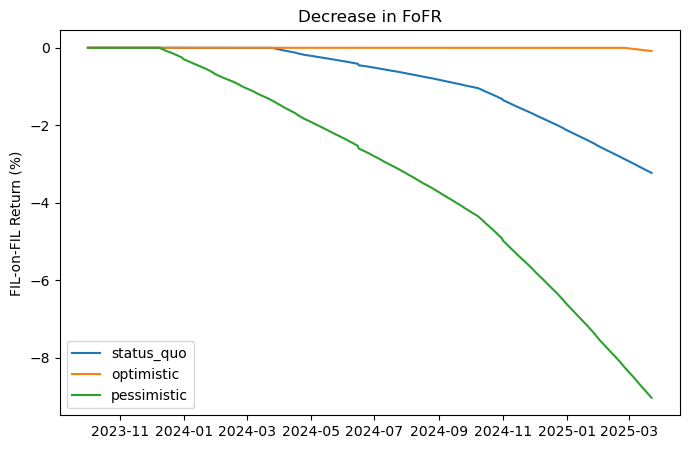

In [21]:
time = 540
plt.figure(figsize=(8,5))
#ax = axs[0]
for onboarding_scenario in diff_dict.keys(): 
    label = onboarding_scenario
    df = diff_dict[onboarding_scenario]
    plt.plot(t[:time], df['1y_sector_roi'][:time] * 100, label=label)
plt.title('Decrease in FoFR')
plt.ylabel('FIL-on-FIL Return (%)')
plt.legend()


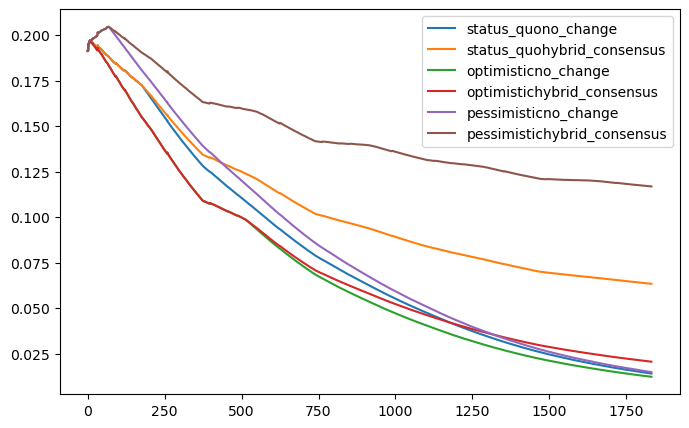

In [22]:
plt.figure(figsize=(8,5))
for onboarding_scenario in diff_dict.keys(): 
    label = onboarding_scenario
    plt.plot(curr_dict[onboarding_scenario]['day_pledge_per_QAP'], label=onboarding_scenario + 'no_change')
    plt.plot(new_dict[onboarding_scenario]['day_pledge_per_QAP'], label=onboarding_scenario + 'hybrid_consensus')

plt.legend()

In [23]:
plt.figure(figsize=(5,3))
#plt.plot(t, new_df['day_locked_pledge'] - new_df['day_renewed_pledge']) 
#plt.plot(t, curr_df['day_locked_pledge'] - curr_df['day_renewed_pledge'])

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

Text(0.5, 1.0, 'Difference in Newly Committed Daily Pledge')

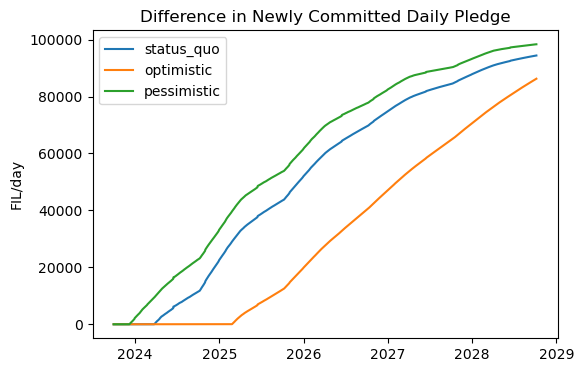

In [24]:
plt.figure(figsize=(6,4))
for onboarding_scenario in diff_dict.keys(): 
    label = onboarding_scenario
    df = diff_dict[onboarding_scenario]
    plt.plot(t, df['day_new_pledge'], label=label)
plt.legend()
plt.ylabel('FIL/day')
plt.title('Difference in Newly Committed Daily Pledge')

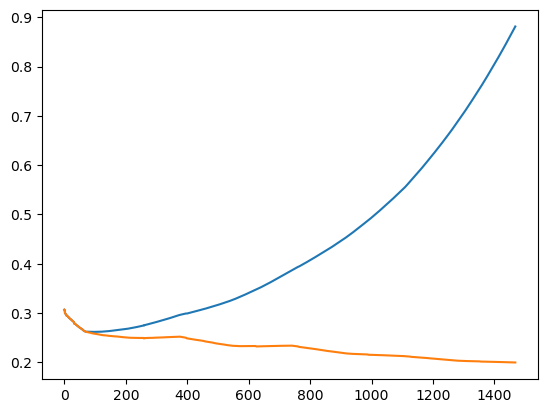

In [25]:
plt.plot(curr_df['1y_sector_roi'])
plt.plot(new_df['1y_sector_roi'])

In [26]:
curr_df.columns

Index(['1y_return_per_sector', '1y_sector_roi', 'capped_power_EIB',
       'circ_supply', 'cum_baseline_reward', 'cum_capped_power_EIB',
       'cum_network_reward', 'cum_simple_reward', 'day_locked_pledge',
       'day_network_reward', 'day_onboarded_power_QAP_PIB',
       'day_pledge_per_QAP', 'day_renewed_pledge', 'day_renewed_power_QAP_PIB',
       'day_rewards_per_sector', 'days', 'disbursed_reserve',
       'full_renewal_rate', 'network_QAP_EIB', 'network_RBP_EIB',
       'network_baseline_EIB', 'network_gas_burn', 'network_locked',
       'network_locked_pledge', 'network_locked_reward', 'network_time',
       'one_year_vest_saft', 'qa_day_onboarded_power_pib',
       'qa_day_renewed_power_pib', 'qa_total_power_eib',
       'rb_day_onboarded_power_pib', 'rb_day_renewed_power_pib',
       'rb_total_power_eib', 'six_month_vest_saft', 'six_year_vest_foundation',
       'six_year_vest_pl', 'six_year_vest_saft', 'three_year_vest_saft',
       'total_day_vest', 'total_vest', 'two_year

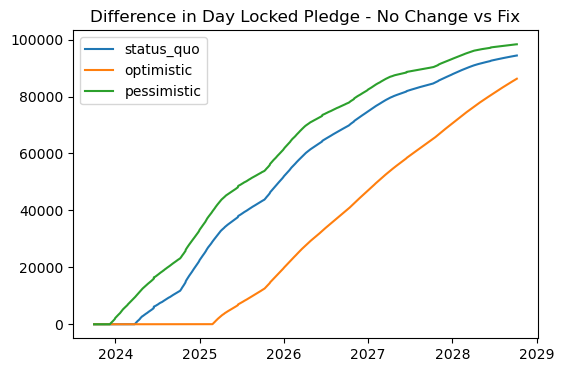

In [27]:
plt.figure(figsize=(6,4))
for onboarding_scenario in diff_dict.keys(): 
    label = onboarding_scenario
    df = diff_dict[onboarding_scenario]
    plt.plot(t, df['day_locked_pledge'] - df['day_renewed_pledge'], label=label)

plt.title('Difference in Day Locked Pledge - No Change vs Fix')

plt.legend()


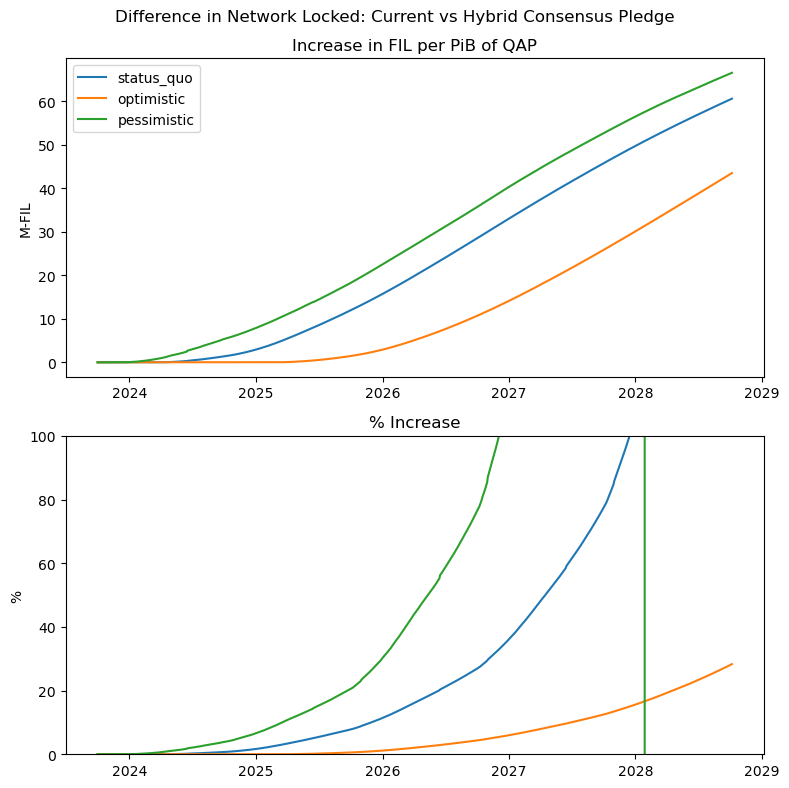

In [28]:
#plt.figure(figsize=(6,4))
fig, axs = plt.subplots(2,1, figsize=(8,8))
#scale_by = 1e6
#for onboarding_scenario in diff_dict.keys(): 
#    label = onboarding_scenario
#    df = diff_dict[onboarding_scenario]
#    plt.plot(t, df['network_locked']/scale_by, label=label)
#plt.ylabel('M-FIL')
#plt.title('Difference in Network Locked: Current vs Hybrid Consensus Pledge')
#plt.legend()

ax = axs[0]
for onboarding_scenario in diff_dict.keys(): 
    label = onboarding_scenario
    df = diff_dict[onboarding_scenario]
    ax.plot(t, df['network_locked'] / 1e6, label=label)
ax.set_title('Increase in FIL per PiB of QAP')
ax.set_ylabel('M-FIL')
ax.legend()

ax = axs[1]
for onboarding_scenario in diff_dict.keys(): 
    label = onboarding_scenario
    df = diff_dict[onboarding_scenario]
    ax.plot(t, df['network_locked_percent'] * 1e2)
ax.set_title('% Increase')
ax.set_ylabel('%')
ax.set_ylim(0, 100)

fig.suptitle('Difference in Network Locked: Current vs Hybrid Consensus Pledge')
plt.tight_layout()

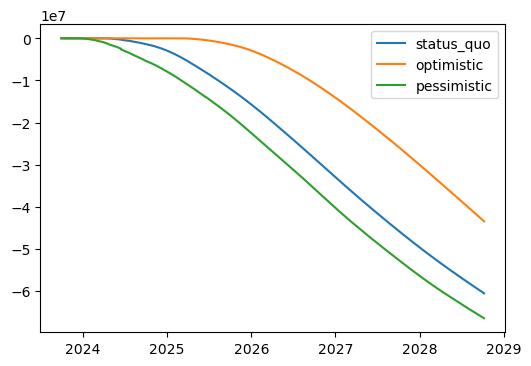

In [29]:
plt.figure(figsize=(6,4))
for onboarding_scenario in diff_dict.keys(): 
    label = onboarding_scenario
    df = diff_dict[onboarding_scenario]
    plt.plot(t, df['circ_supply']  , label=label)

plt.legend()

In [30]:
6 * 100000

600000

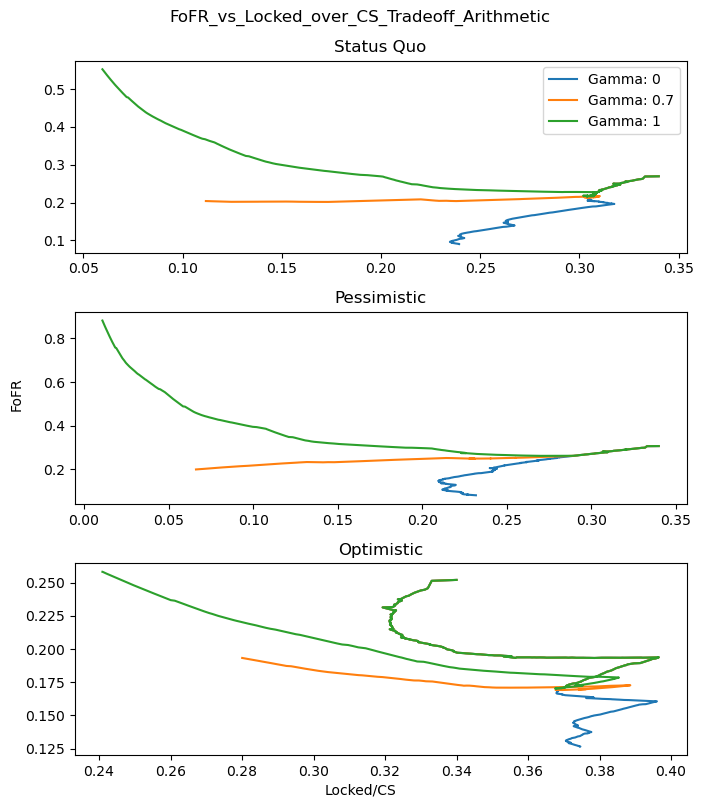

In [31]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7,8))

for gamma_scenario in scenario2results_arithmetic.keys(): 
    res_status_quo = scenario2results_arithmetic[gamma_scenario]['status_quo']
    res_pessimistic = scenario2results_arithmetic[gamma_scenario]['pessimistic']
    res_optimistic = scenario2results_arithmetic[gamma_scenario]['optimistic']

    ax[0].plot(res_status_quo['network_locked'] / res_status_quo['circ_supply'],res_status_quo['1y_sector_roi'], label='Gamma: ' + gamma_scenario)
    ax[0].set_title('Status Quo')
    
    ax[1].plot(res_pessimistic['network_locked'] / res_pessimistic['circ_supply'], res_pessimistic['1y_sector_roi'])
    ax[1].set_title('Pessimistic')
    
    ax[2].plot(res_optimistic['network_locked'] / res_optimistic['circ_supply'], res_optimistic['1y_sector_roi'])
    ax[2].set_title('Optimistic')

fig.text(0.5, 0, 'Locked/CS', ha='center')
# Common y-label
fig.text(0, 0.5, 'FoFR', va='center', rotation='vertical')
   
title = 'FoFR_vs_Locked_over_CS_Tradeoff_Arithmetic'
fig.suptitle(title)
ax[0].legend()
plt.tight_layout()

plt.savefig(os.getcwd() + '/' + title, bbox_inches='tight')

    

In [32]:
new_dict['status_quo'] - curr_dict['status_quo']

,1y_return_per_sector,1y_sector_roi,capped_power_EIB,circ_supply,cum_baseline_reward,cum_capped_power_EIB,cum_network_reward,cum_simple_reward,day_locked_pledge,day_network_reward,...,rb_day_renewed_power_pib,rb_total_power_eib,six_month_vest_saft,six_year_vest_foundation,six_year_vest_pl,six_year_vest_saft,three_year_vest_saft,total_day_vest,total_vest,two_year_vest_saft
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1828,NaN,NaN,0.0,-60406592.0,0.0,0.0,0.0,0.0,180795.640625,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1829,NaN,NaN,0.0,-60443072.0,0.0,0.0,0.0,0.0,180854.578125,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1830,NaN,NaN,0.0,-60479552.0,0.0,0.0,0.0,0.0,180909.609375,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1831,NaN,NaN,0.0,-60516096.0,0.0,0.0,0.0,0.0,180962.859375,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Geometric

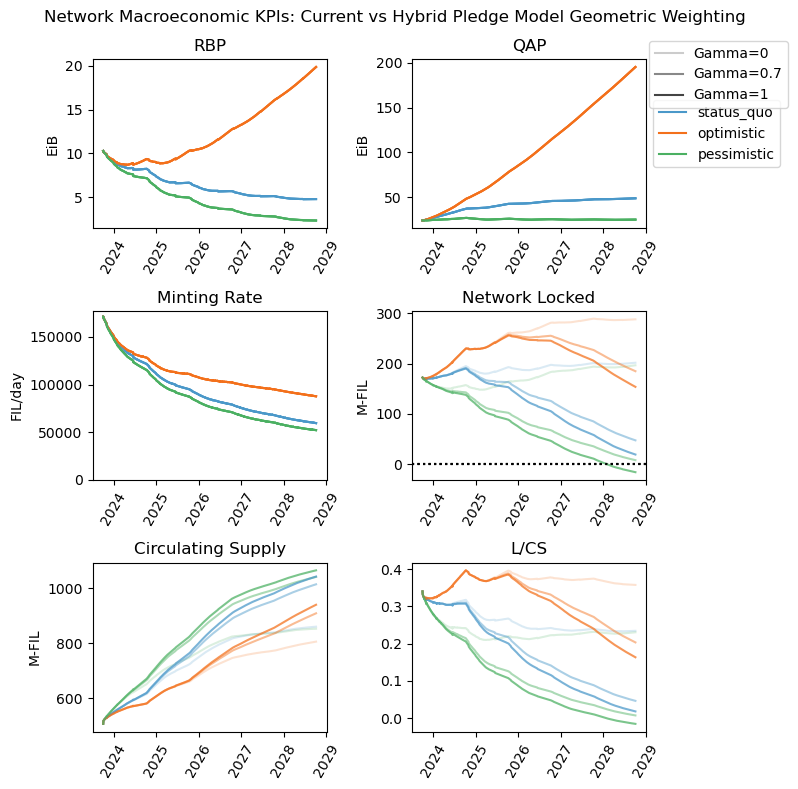

In [33]:
total_sim_len = (end_date - start_date).days
t = [start_date + timedelta(days=i) for i in range(total_sim_len)]
gamma_weight_type = 'Geometric'
scenario2results = scenario2results_geometric

plot_macroeconomic_weighting(total_sim_len,
                             t, 
                             scenario2results, 
                             gamma_weights, 
                             gamma_weight_type=gamma_weight_type, 
                            )

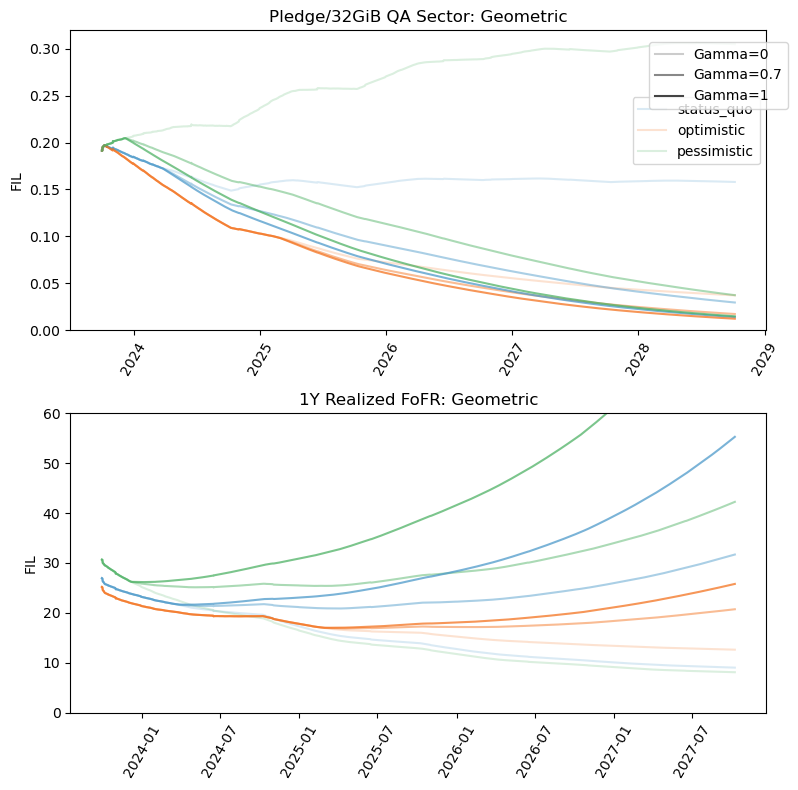

In [34]:
total_sim_len = (end_date - start_date).days
t = [start_date + timedelta(days=i) for i in range(total_sim_len)]
gamma_weight_type = 'Geometric'
scenario2results = scenario2results_geometric
plot_microeconomic_trajectories(total_sim_len,
                             t, 
                             scenario2results, 
                             gamma_weights, 
                             gamma_weight_type=gamma_weight_type, 
                            )

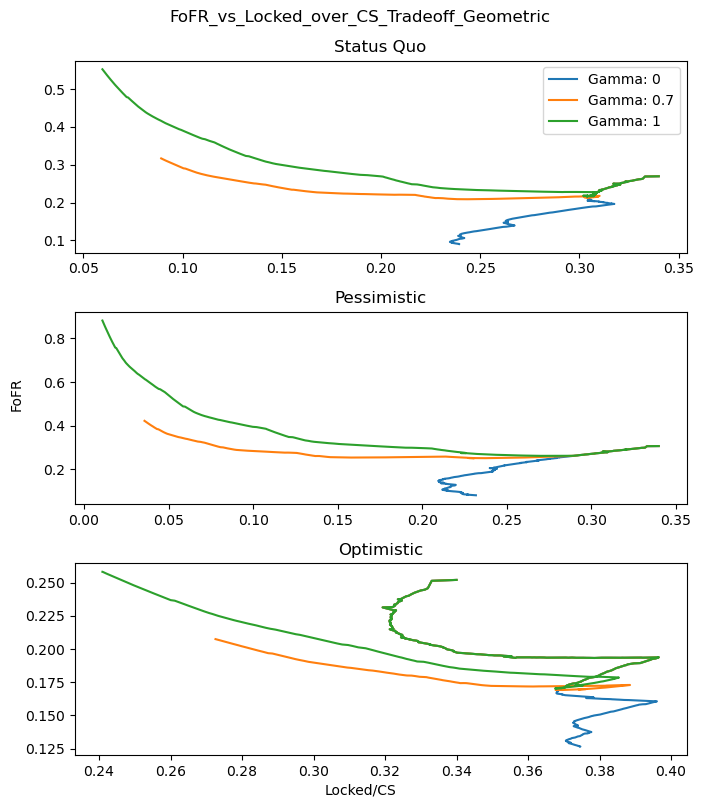

In [35]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7,8))

for gamma_scenario in scenario2results_geometric.keys(): 
    res_status_quo = scenario2results_geometric[gamma_scenario]['status_quo']
    res_pessimistic = scenario2results_geometric[gamma_scenario]['pessimistic']
    res_optimistic = scenario2results_geometric[gamma_scenario]['optimistic']

    ax[0].plot(res_status_quo['network_locked'] / res_status_quo['circ_supply'],res_status_quo['1y_sector_roi'], label='Gamma: ' + gamma_scenario)
    ax[0].set_title('Status Quo')
    
    ax[1].plot(res_pessimistic['network_locked'] / res_pessimistic['circ_supply'], res_pessimistic['1y_sector_roi'])
    ax[1].set_title('Pessimistic')
    
    ax[2].plot(res_optimistic['network_locked'] / res_optimistic['circ_supply'], res_optimistic['1y_sector_roi'])
    ax[2].set_title('Optimistic')

fig.text(0.5, 0, 'Locked/CS', ha='center')
# Common y-label
fig.text(0, 0.5, 'FoFR', va='center', rotation='vertical')
   
title = 'FoFR_vs_Locked_over_CS_Tradeoff_Geometric'
fig.suptitle(title)
ax[0].legend()
plt.tight_layout()

plt.savefig(os.getcwd() + '/' + title, bbox_inches='tight')

### Harmonic

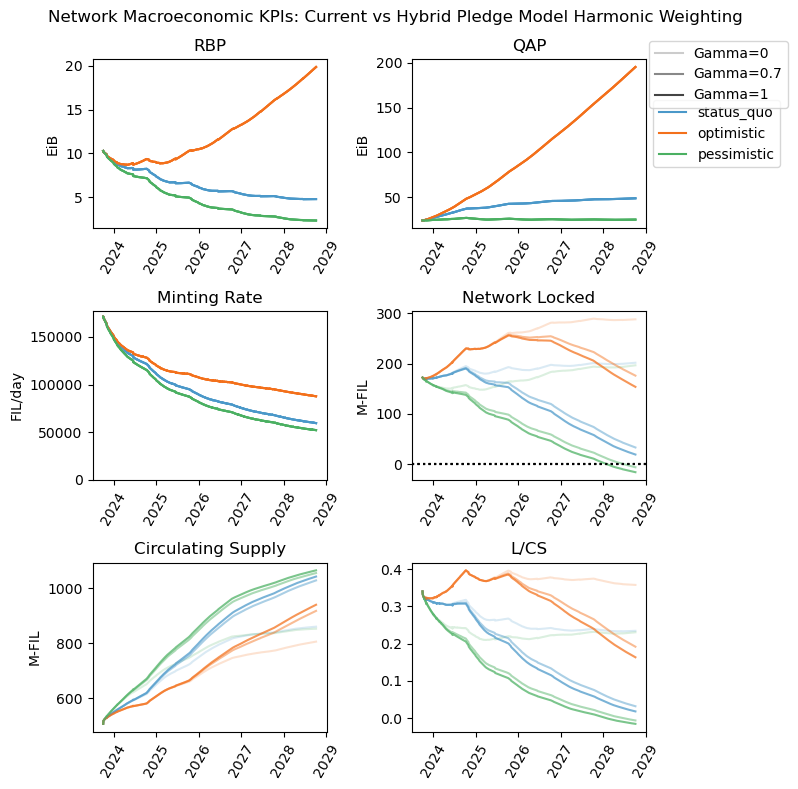

In [36]:
total_sim_len = (end_date - start_date).days
t = [start_date + timedelta(days=i) for i in range(total_sim_len)]
gamma_weight_type = 'Harmonic'
scenario2results = scenario2results_harmonic

plot_macroeconomic_weighting(total_sim_len,
                             t, 
                             scenario2results, 
                             gamma_weights, 
                             gamma_weight_type=gamma_weight_type, 
                            )

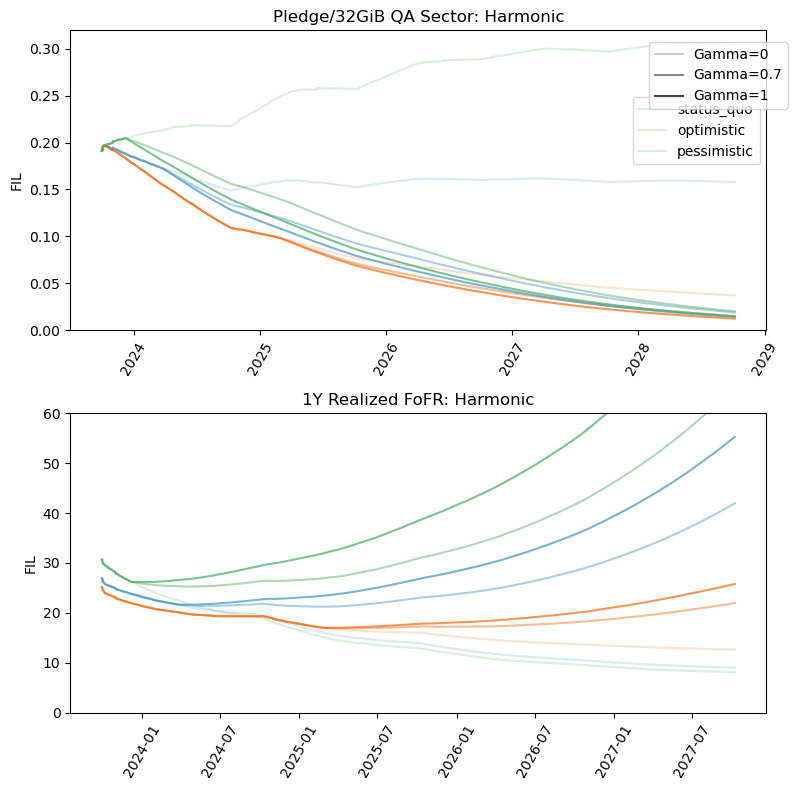

In [37]:
total_sim_len = (end_date - start_date).days
t = [start_date + timedelta(days=i) for i in range(total_sim_len)]
gamma_weight_type = 'Harmonic'
scenario2results = scenario2results_harmonic
plot_microeconomic_trajectories(total_sim_len,
                             t, 
                             scenario2results, 
                             gamma_weights, 
                             gamma_weight_type=gamma_weight_type, 
                            )

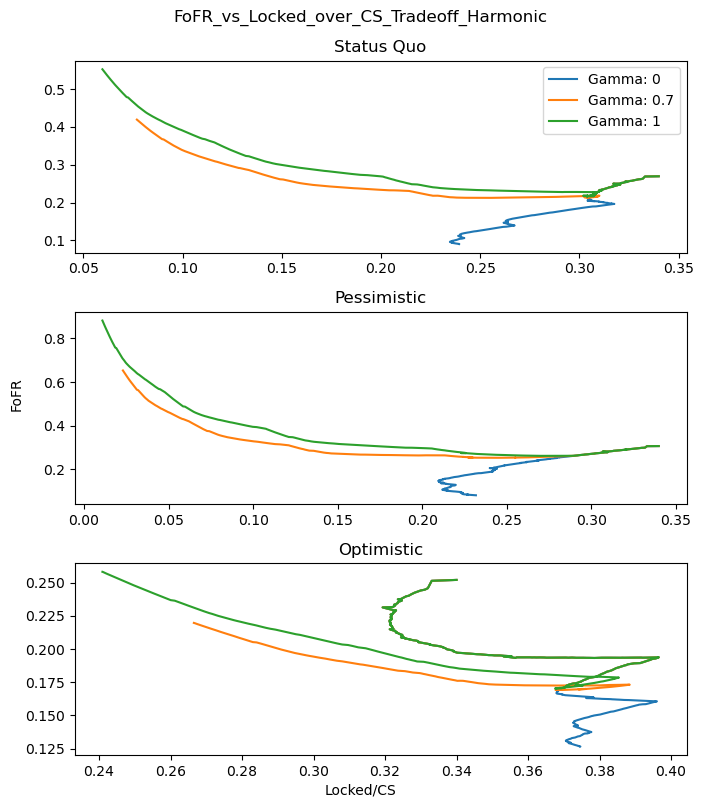

In [38]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7,8))

for gamma_scenario in scenario2results_harmonic.keys(): 
    res_status_quo = scenario2results_harmonic[gamma_scenario]['status_quo']
    res_pessimistic = scenario2results_harmonic[gamma_scenario]['pessimistic']
    res_optimistic = scenario2results_harmonic[gamma_scenario]['optimistic']

    ax[0].plot(res_status_quo['network_locked'] / res_status_quo['circ_supply'],res_status_quo['1y_sector_roi'], label='Gamma: ' + gamma_scenario)
    ax[0].set_title('Status Quo')
    
    ax[1].plot(res_pessimistic['network_locked'] / res_pessimistic['circ_supply'], res_pessimistic['1y_sector_roi'])
    ax[1].set_title('Pessimistic')
    
    ax[2].plot(res_optimistic['network_locked'] / res_optimistic['circ_supply'], res_optimistic['1y_sector_roi'])
    ax[2].set_title('Optimistic')

fig.text(0.5, 0, 'Locked/CS', ha='center')
# Common y-label
fig.text(0, 0.5, 'FoFR', va='center', rotation='vertical')
   
title = 'FoFR_vs_Locked_over_CS_Tradeoff_Harmonic'
fig.suptitle(title)
ax[0].legend()
plt.tight_layout()

plt.savefig(os.getcwd() + '/' + title, bbox_inches='tight')

## Macroeconomic Plot

In [39]:
def plot_x(ax, results, key, labels, colors, scale_by=1, linestyle='-', alpha=1):
    for ii, scenario in enumerate(labels):
        res = results[scenario]
        ax.plot(t, res[key]/scale_by, label=scenario, color=colors[ii], linestyle=linestyle, alpha=alpha)
        
    for tick in ax.get_xticklabels():
        tick.set_rotation(60)

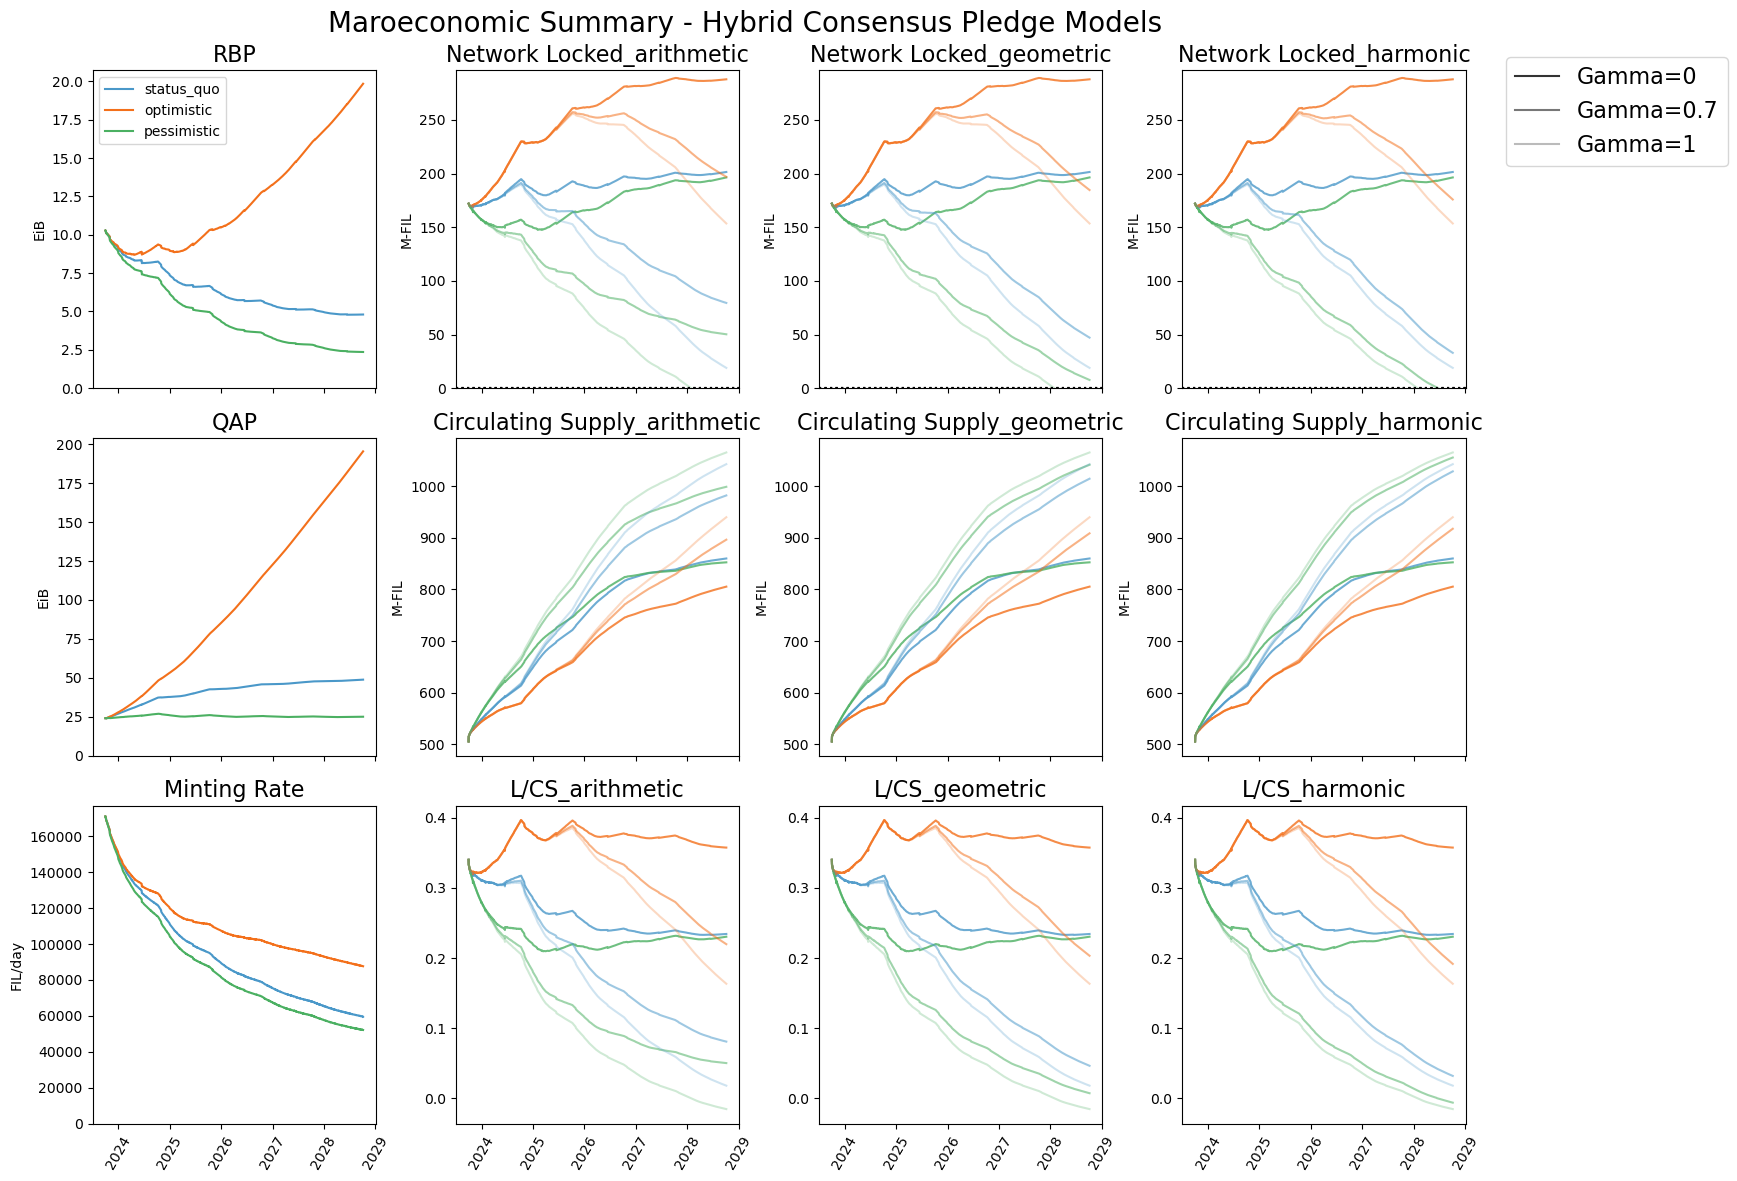

In [40]:
mpl.rcParams['figure.figsize'] = (15, 20)
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(15,12), sharex=True)
c_vec = [c(0.6) for c in colors]
fontsize = 16

## Plot RBP, QAP, and Minting (Which Remain invariant)
gamma_scenario = '0'
linestyle = '-'
keys = list(scenario2results[gamma_scenario].keys())
axx = ax[0, 0]
plot_x(axx, scenario2results[gamma_scenario], 'rb_total_power_eib', keys, c_vec, linestyle=linestyle)
#axx.set_yscale('log')
axx.set_ylabel('EiB')
axx.set_ylim(0)
axx.set_title('RBP', fontsize=fontsize)
axx.legend()
# Dont need to duplicate legends

axx = ax[1, 0]
plot_x(axx, scenario2results[gamma_scenario], 'qa_total_power_eib', keys, c_vec, linestyle=linestyle)
#axx.set_yscale('log')
axx.set_ylim(0)
axx.set_ylabel('EiB')
axx.set_title('QAP', fontsize=fontsize)
#if gamma_scenario == str(0): 
 #   axx.legend(bbox_to_anchor=(0, 1))

axx = ax[2, 0]
plot_x(axx, scenario2results[gamma_scenario], 'day_network_reward', keys, c_vec, linestyle=linestyle)
axx.set_ylabel('FIL/day')
axx.set_ylim(0)
axx.set_title('Minting Rate', fontsize=fontsize)

for idx_weight_scenario, weight_scenario in enumerate(scenario2results_new.keys()): 
    
    scenario2results = scenario2results_new[weight_scenario]
    
    for idx, gamma_scenario in enumerate(gamma_weights): 
        spacing = 0.8 / len(gamma_weights)
        alpha = 0.2 + spacing * idx
        alpha = 1 - alpha
        
        gamma_scenario = str(gamma_scenario)
        linestyle = '-'
        
        keys = list(scenario2results[gamma_scenario].keys())
        
        column = idx_weight_scenario + 1
        axx = ax[0, column]
        plot_x(axx, scenario2results[gamma_scenario], 'network_locked', keys, c_vec, scale_by=1e6, linestyle=linestyle, alpha=alpha)
        axx.set_ylabel('M-FIL')
        axx.set_title('Network Locked_' + weight_scenario, fontsize=fontsize)
        axx.set_ylim(0)
        axx.axhline(0, linestyle=':', color='k')

        axx = ax[1, column]
        plot_x(axx, scenario2results[gamma_scenario], 'circ_supply', keys, c_vec, scale_by=1e6, linestyle=linestyle, alpha=alpha)
        axx.set_ylabel('M-FIL')
        #axx.set_ylim(0, 1500)
        axx.set_title('Circulating Supply_' + weight_scenario, fontsize=fontsize)

        axx = ax[2, column]

        for ii, scenario in enumerate(keys):
            res = scenario2results[gamma_scenario][scenario]
            axx.plot(t, res['network_locked']/res['circ_supply'], label= str(gamma_scenario)+':'+keys[ii], color=c_vec[ii], linestyle=linestyle, alpha=alpha)
        for tick in axx.get_xticklabels():
            tick.set_rotation(60)
        axx.set_title('L/CS_' + weight_scenario, fontsize=fontsize)

#fig.suptitle('Network Macroeconomic KPIs: Current vs Hybrid Pledge Model ' + gamma_weight_type + ' Weighting' )

# Create a list to store the legend handles
legend_handles = []

# Loop through the gamma weights and create Line2D objects for each gamma_scenario
for idx, gamma_scenario in enumerate(gamma_weights):  
    spacing = 0.8 / len(gamma_weights)
    alpha = 0.2 + spacing*idx
    alpha = 1 - alpha
    label = f'Gamma={gamma_scenario}'
    line = Line2D([], [], linestyle='-', color='black', label=label, alpha=alpha)
    legend_handles.append(line)

# Add the legend to the plot
#fig.legend(handles=legend_handles, bbox_to_anchor=(1, 0.7), loc='center right')
fig.legend(handles=legend_handles, bbox_to_anchor = (1,0.95), loc='upper left', fontsize=fontsize)

fig.suptitle('Maroeconomic Summary - Hybrid Consensus Pledge Models', fontsize = 20)
plt.tight_layout()
plt.savefig('Macroeconomic_Summary_Hybrid_Consensus_Mechanisms', bbox_inches = 'tight')

## Microeconomic Plot (Pledge and FoFR)

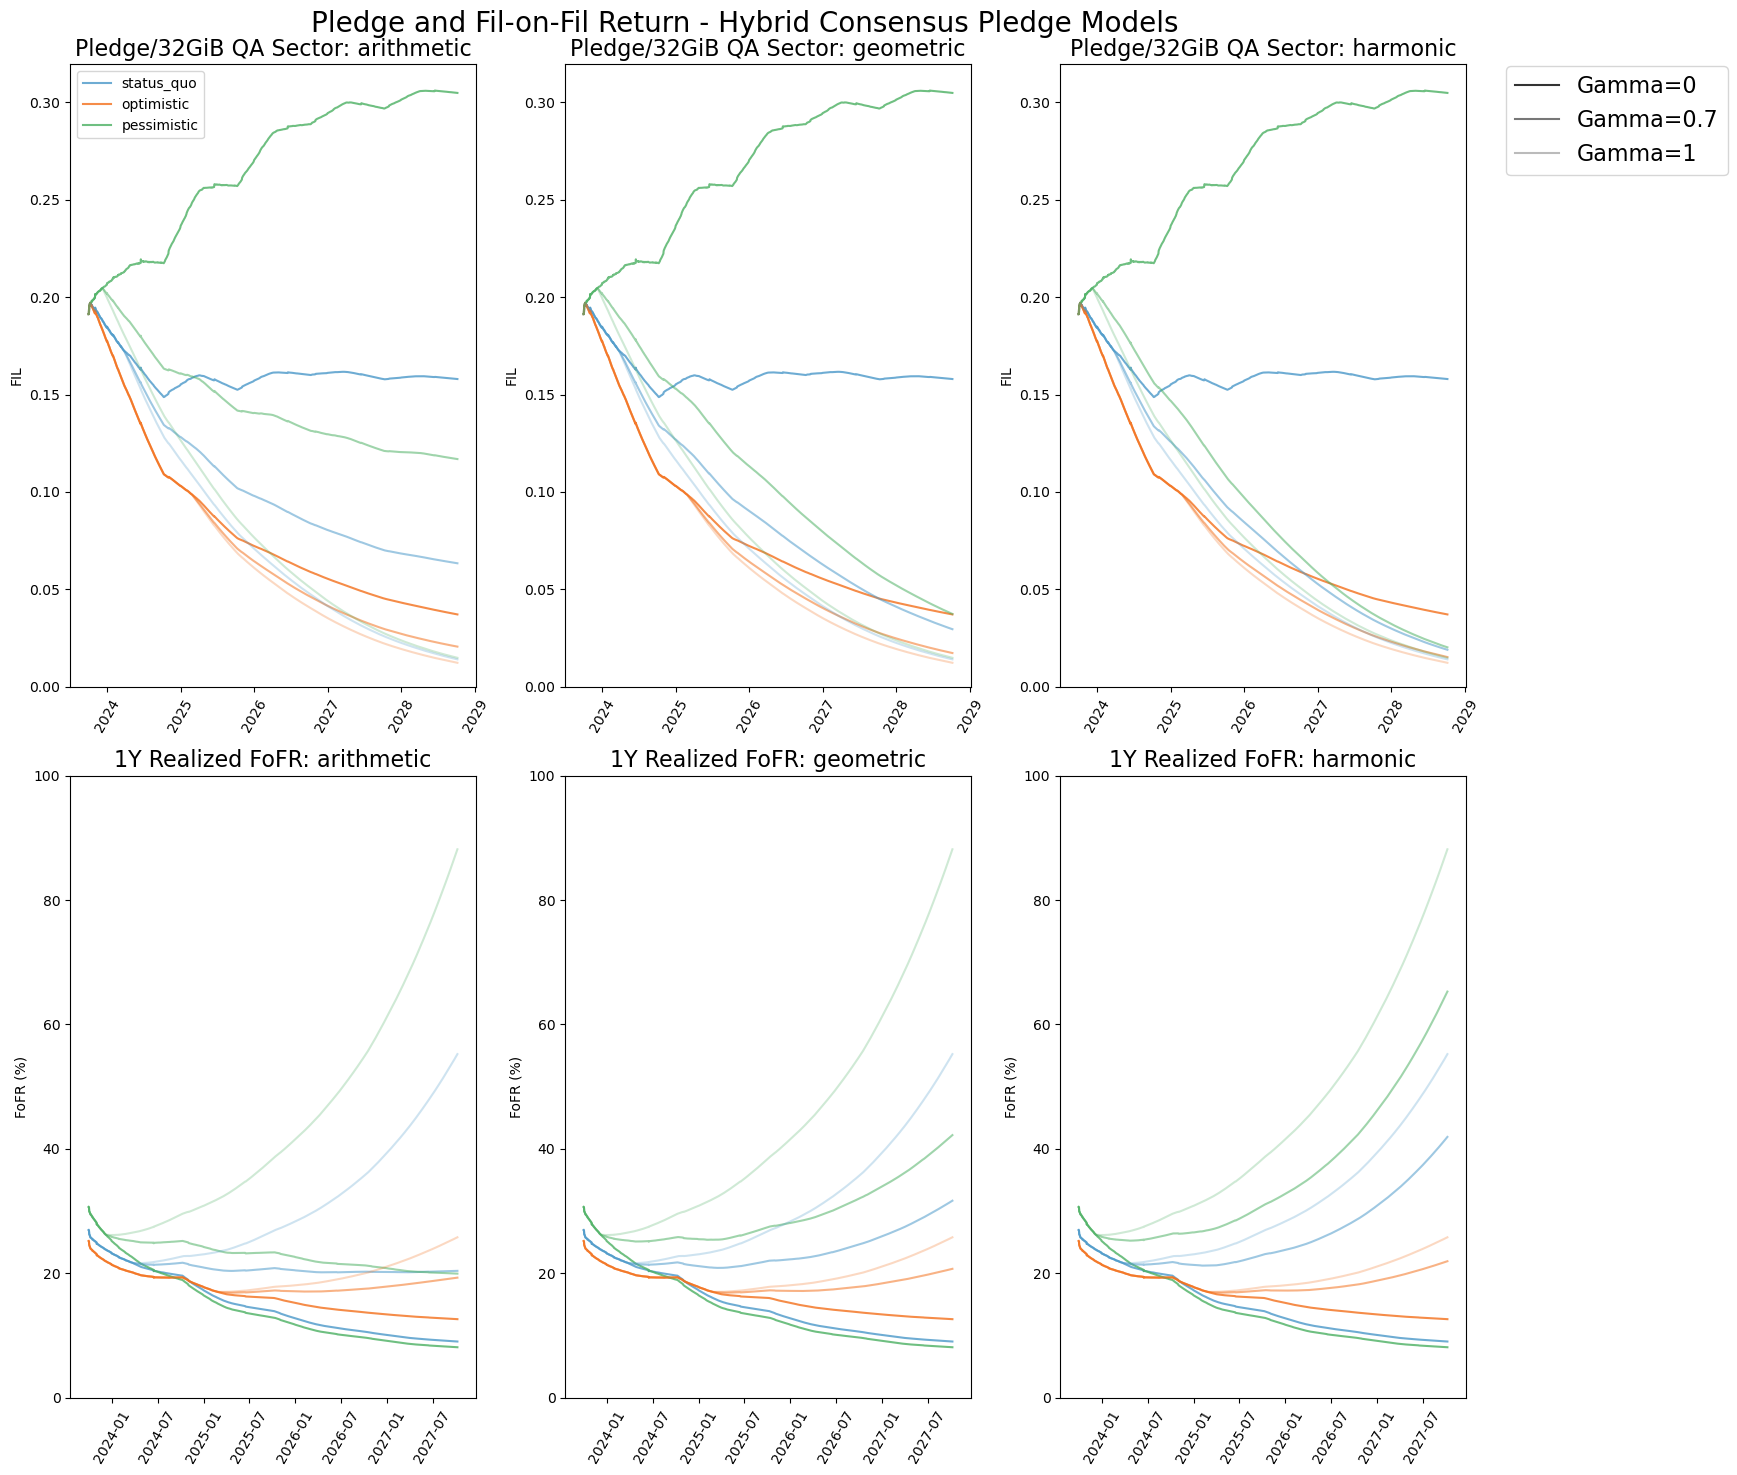

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,15))
c_vec = [c(0.6) for c in colors]
legend_handles = []
fontsize = 16

for idx_weight_scenario, weight_scenario in enumerate(scenario2results_new.keys()): 
    
    scenario2results = scenario2results_new[weight_scenario]
    
    for idx, gamma_scenario in enumerate(gamma_weights): 
        
        spacing = 0.8 / len(gamma_weights)
        alpha = 0.2 + spacing*idx
        alpha = 1 - alpha
        
        gamma_scenario = str(gamma_scenario)
        keys = list(scenario2results[gamma_scenario].keys())
        linestyle = '-'

        axx = ax[0, idx_weight_scenario]
        plot_x(axx, scenario2results[gamma_scenario], 'day_pledge_per_QAP', keys, c_vec, linestyle=linestyle, alpha=alpha)
        axx.set_ylabel('FIL')
        axx.set_title('Pledge/32GiB QA Sector: ' + weight_scenario, fontsize=fontsize)
        axx.set_ylim(0)
        #axx.legend(bbox_to_anchor=(1,0.5))
        if gamma_scenario == str(0) and idx_weight_scenario == 0: 
            axx.legend(loc='best') 

        axx = ax[1, idx_weight_scenario]
        plot_x(axx, scenario2results[gamma_scenario], '1y_sector_roi', keys, c_vec, scale_by=.01, linestyle=linestyle, alpha=alpha)
        axx.set_ylabel('FoFR (%)')
        axx.set_title('1Y Realized FoFR: ' + weight_scenario, fontsize=fontsize)
        axx.set_ylim(0,100)
   
  
for idx, gamma_scenario in enumerate(gamma_weights):  
    spacing = 0.8 / len(gamma_weights)
    alpha = 0.2 + spacing*idx
    alpha = 1 - alpha
    label = f'Gamma={gamma_scenario}'
    line = Line2D([], [], linestyle='-', color='black', label=label, alpha=alpha)
    legend_handles.append(line)

# Add the legend to the plot
fig.legend(handles=legend_handles, bbox_to_anchor=(1, 0.95), loc='upper left', fontsize = 16)
fig.suptitle('Pledge and Fil-on-Fil Return - Hybrid Consensus Pledge Models', fontsize=20)
plt.tight_layout()
plt.savefig('Pledge_FoFR_MicroSummary', bbox_inches='tight')

## FoFR vs Locked Supply Tradeoff

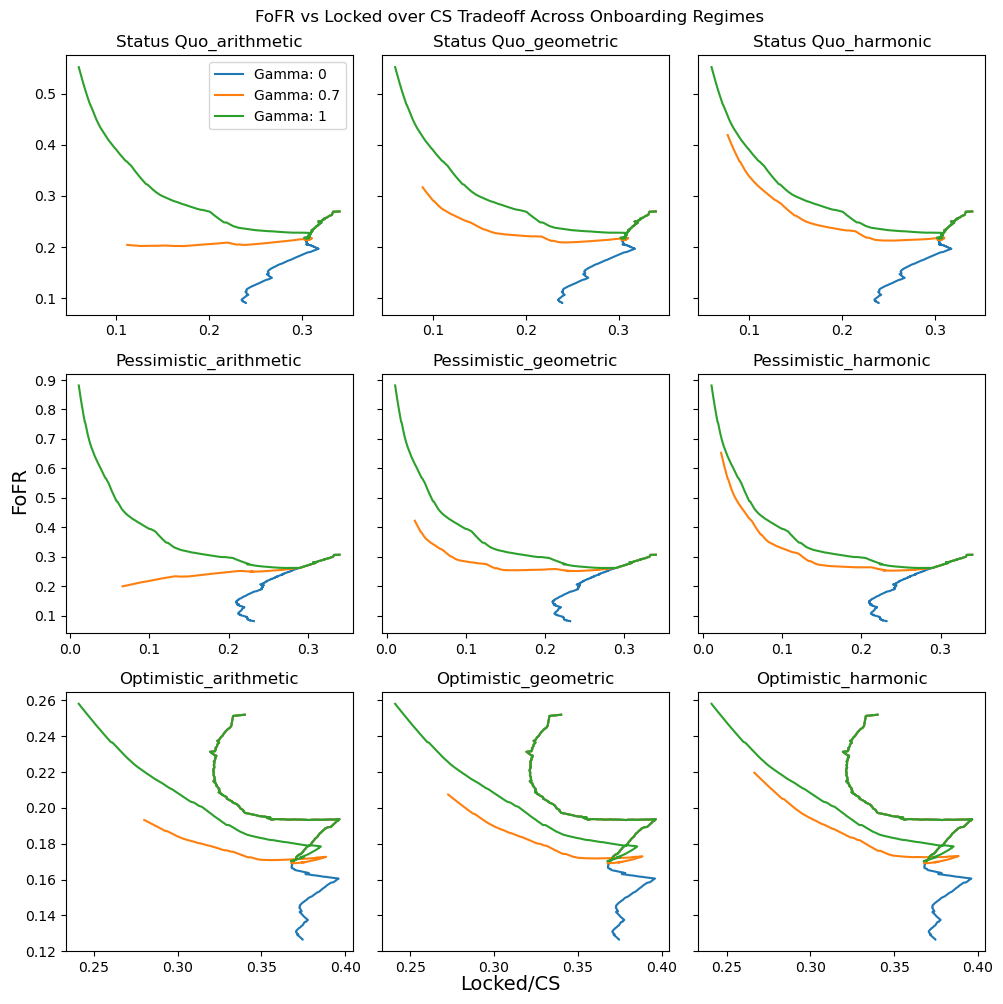

In [42]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharey = 'row',  figsize = (10, 10))
fontsize = 16

# plot scatter 
for idx_weight_scenario, weight_scenario in enumerate(scenario2results_new.keys()): 
    
    scenario2results = scenario2results_new[weight_scenario]
    
    for gamma_scenario in scenario2results.keys(): 
        res_status_quo = scenario2results[gamma_scenario]['status_quo']
        res_pessimistic = scenario2results[gamma_scenario]['pessimistic']
        res_optimistic = scenario2results[gamma_scenario]['optimistic']
        
        #axx = ax[0, idx_weight_scenario]
        axs[0, idx_weight_scenario].plot(res_status_quo['network_locked'] / res_status_quo['circ_supply'],res_status_quo['1y_sector_roi'], label='Gamma: ' + gamma_scenario)
        axs[0, idx_weight_scenario].set_title('Status Quo_' + weight_scenario)
        if idx_weight_scenario == 0: 
            axs[0, idx_weight_scenario].legend(loc='best')
        
        #axx = ax[1, idx_weight_scenario]
        axs[1, idx_weight_scenario].plot(res_pessimistic['network_locked'] / res_pessimistic['circ_supply'], res_pessimistic['1y_sector_roi'])
        axs[1, idx_weight_scenario].set_title('Pessimistic_' + weight_scenario)

        #axx = ax[2, idx_weight_scenario]
        axs[2, idx_weight_scenario].plot(res_optimistic['network_locked'] / res_optimistic['circ_supply'], res_optimistic['1y_sector_roi'])
        axs[2, idx_weight_scenario].set_title('Optimistic_' + weight_scenario)
    
fig.text(0.5, 0, 'Locked/CS', ha='center', fontsize=14)
# Common y-label
fig.text(0, 0.5, 'FoFR', va='center', rotation='vertical', fontsize = 14)
   
title = 'FoFR vs Locked over CS Tradeoff Across Onboarding Regimes'
fig.suptitle(title)
plt.tight_layout()

plt.savefig('FoFR_vs_LockedCS_Tradeoff_Summary', bbox_inches='tight')

In [43]:
gamma_scenario

'1'

## Implementing Pre and Post Crossing 

In [44]:
scenario2results_full.keys()

dict_keys(['status_quo', 'optimistic', 'pessimistic'])